<a href="https://colab.research.google.com/github/RajuMopidevi/MelanomaDetection/blob/main/SudharsanRaju_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement**:  To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

Image files size are ~ 800MB; Tensor flow reads the files from local execution directory. In order to allow this .ipynb file run without any issues, Images must be placed in the public accesible location. **Instead of allocating personal google drive** location to public, I have choose to **download the images directly from github**. 

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
%%bash
git clone https://github.com/RajuMopidevi/MelanomaDetection

Cloning into 'MelanomaDetection'...
Checking out files: 100% (2359/2359), done.


In [3]:
%cd MelanomaDetection/datasets
%ls -ltr


/content/MelanomaDetection/datasets
total 8
drwxr-xr-x 11 root root 4096 Oct 19 15:42 Test/
drwxr-xr-x 11 root root 4096 Oct 19 15:42 Train/


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## As per above command, images are cloned to /content 
data_dir_train = pathlib.Path("/content/MelanomaDetection/datasets/Train")
data_dir_test = pathlib.Path('/content/MelanomaDetection/datasets/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

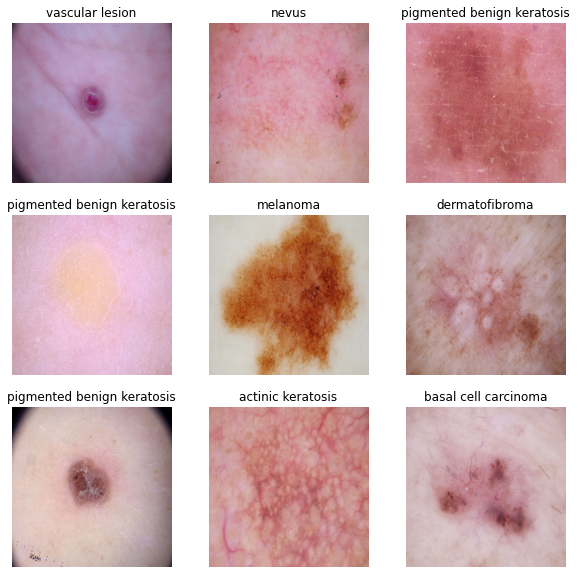

In [11]:
# Display one instance of all nine classes present in the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### normalise the data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.032352764 0.8284314


In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
###  optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 13s 73ms/step - loss: 2.1130 - accuracy: 0.2310 - val_loss: 1.8133 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.7021 - accuracy: 0.3929 - val_loss: 1.7509 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.5257 - accuracy: 0.4593 - val_loss: 1.4826 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4211 - accuracy: 0.4983 - val_loss: 1.4310 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3493 - accuracy: 0.5296 - val_loss: 1.4317 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3533 - accuracy: 0.5195 - val_loss: 1.4042 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2420 - accuracy: 0.5631 - val_loss: 1.3279 - val_accuracy: 0.5414
Epoch 8/20
5

### Visualizing training results

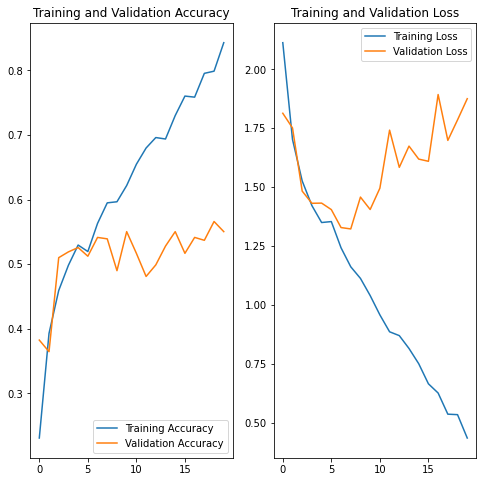

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Model 1: Findings


*   Training accuracy increased with the increase of Epoch, where as testing accuracy is only around 55% on the validation set.
*   Training accuracy is becoming linear where as testing accuracy is humping at 50-55%
*   The difference between training and validation accuracy is a sign of overfitting. 
*   Training loss decreses with increase in epochs but validation loss decreases first with increse in epochs and then become constant.
*   Overfitting happened since we have less number of training images and model has learnt from noise or unwanted details around the training data.
* Lets use Data augmentation which will add additional training data by applying transformation on existing data

### Data Augmentation
Data augmentation aims to generate additional training data from already existing examples through the application of random transformations. The model is just exposed to more details of the data to help performance and its ability to generalise. Here, images are randomly flipped, rotated and zoomed to augment the data. For cancer detection, elements such as brightness and saturation are important for the disease detection. Therefore, those parameters are not going to be altered for data augmentation.

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

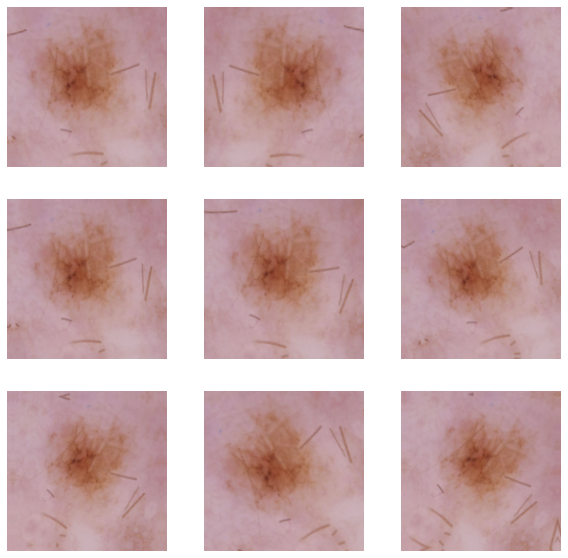

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


### Dropout layer
Here, dropout regularisation is introduced to the network. It randomly drops out a number of output units from the layer during the training process.

In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 44ms/step - loss: 2.0488 - accuracy: 0.2617 - val_loss: 1.8244 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7692 - accuracy: 0.3566 - val_loss: 1.6108 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6111 - accuracy: 0.4319 - val_loss: 1.5410 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5001 - accuracy: 0.4727 - val_loss: 1.4462 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4202 - accuracy: 0.5073 - val_loss: 1.5514 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3620 - accuracy: 0.5184 - val_loss: 1.4684 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3503 - accuracy: 0.5229 - val_loss: 1.4102 - val_accuracy: 0.4899
Epoch 8/20
56

### Visualizing the results

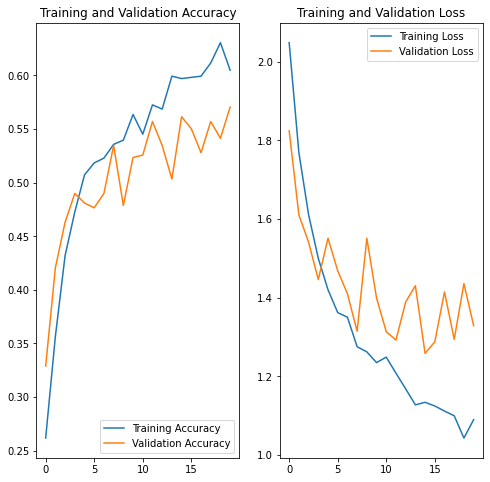

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## Model 2 : Findings

 *       With the increase in number of epochs training and validation both accuracy increases
 *       Training and validation accuracy are almost equal hence overfitting problem resolved
 *       Current model is underfitting since the model accuracy has been decreased from .90 to .62




#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## display list of classes
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/MelanomaDetection/datasets/Train/acti...,actinic keratosis
1,/content/MelanomaDetection/datasets/Train/acti...,actinic keratosis
2,/content/MelanomaDetection/datasets/Train/acti...,actinic keratosis
3,/content/MelanomaDetection/datasets/Train/acti...,actinic keratosis
4,/content/MelanomaDetection/datasets/Train/acti...,actinic keratosis
...,...,...
2234,/content/MelanomaDetection/datasets/Train/vasc...,vascular lesion
2235,/content/MelanomaDetection/datasets/Train/vasc...,vascular lesion
2236,/content/MelanomaDetection/datasets/Train/vasc...,vascular lesion
2237,/content/MelanomaDetection/datasets/Train/vasc...,vascular lesion


<BarContainer object of 9 artists>

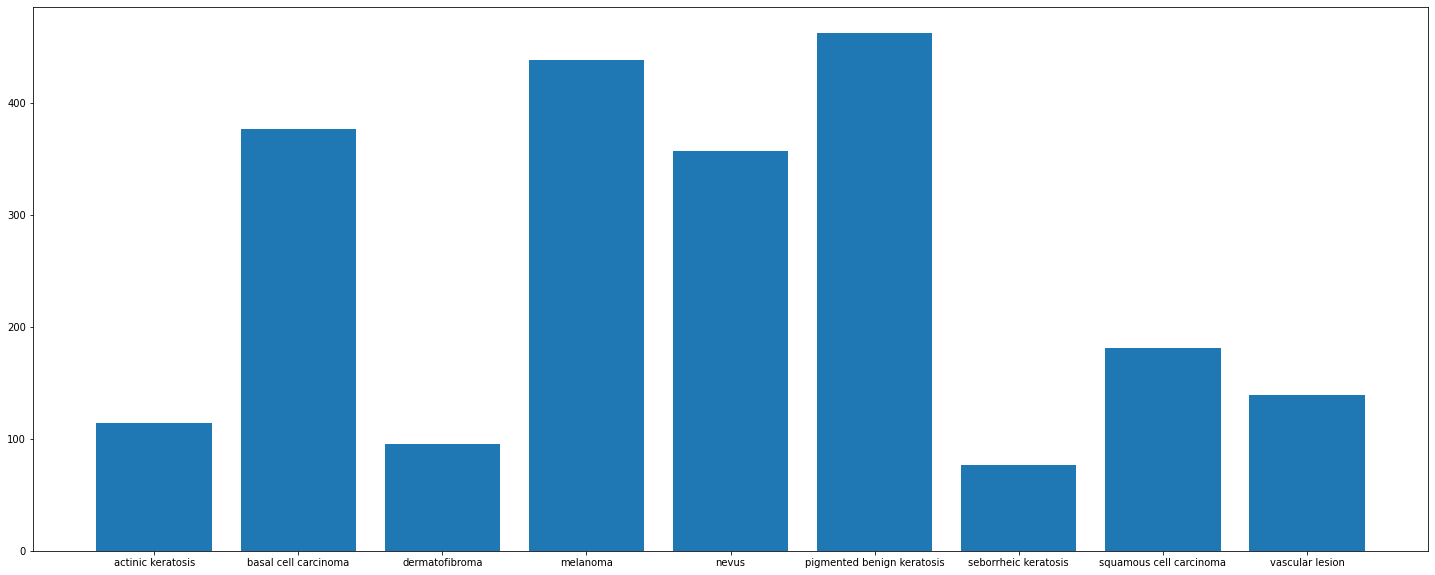

In [28]:
## visualise classes
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
      ans) seborrheic keratosis, at under 100 samples
#### - Which classes dominate the data in terms proportionate number of samples?
      ans) Pigmented benign keratosis have the most and proportionate number of samples at around 450


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
#path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/MelanomaDetection/datasets/Train/"  +i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98D5542A50>: 100%|██████████| 500/500 [00:16<00:00, 30.59 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98D5336F90>: 100%|██████████| 500/500 [00:16<00:00, 30.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98D576B950>: 100%|██████████| 500/500 [00:18<00:00, 26.62 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F98D53272D0>: 100%|██████████| 500/500 [01:21<00:00,  6.12 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98D52D3050>: 100%|██████████| 500/500 [01:08<00:00,  7.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98D575ADD0>: 100%|██████████| 500/500 [00:16<00:00, 30.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F98EA36EB10>: 100%|██████████| 500/500 [00:37<00:00, 13.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9940141950>: 100%|██████████| 500/500 [00:16<00:00, 30.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/MelanomaDetection/datasets/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98D52F3890>: 100%|██████████| 500/500 [00:16<00:00, 29.93 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/MelanomaDetection/datasets/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029297.jpg_308b5351-38c9-40da-ac90-76dd8537735d.jpg',
 '/content/MelanomaDetection/datasets/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_770061f4-360e-440c-a647-f9de1cd41959.jpg',
 '/content/MelanomaDetection/datasets/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025594.jpg_fa7bc6b2-73fa-42f8-bb1e-489e5442fed3.jpg',
 '/content/MelanomaDetection/datasets/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026313.jpg_00aacd70-a4e9-4b3a-b7f2-11ca3870bc57.jpg',
 '/content/MelanomaDetection/datasets/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032642.jpg_66fc93c8-a005-481d-8b2d-eeb830da6ec4.jpg',
 '/content/MelanomaDetection/datasets/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029973.jpg_b6a32531-ed55-4be5-989a-ac5135f7f8d2.jpg',
 '/content/MelanomaDetection/datasets/Train/dermatofibroma/output/dermatofibroma_original_ISIC_00312

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [36]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
data_dir_train1="/content/MelanomaDetection/datasets/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',  activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',  activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.35))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [47]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [48]:
epochs = 30
## Your code goes here, use 50 epochs. 
## Above instruction conflicts with defaulted input 30. 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 27s 153ms/step - loss: 2.0294 - accuracy: 0.2198 - val_loss: 1.7054 - val_accuracy: 0.3534
Epoch 2/30
169/169 [==============================] - 26s 152ms/step - loss: 1.6257 - accuracy: 0.3854 - val_loss: 1.4663 - val_accuracy: 0.4395
Epoch 3/30
169/169 [==============================] - 26s 151ms/step - loss: 1.4929 - accuracy: 0.4273 - val_loss: 1.3376 - val_accuracy: 0.4811
Epoch 4/30
169/169 [==============================] - 26s 152ms/step - loss: 1.3586 - accuracy: 0.4794 - val_loss: 1.2713 - val_accuracy: 0.5152
Epoch 5/30
169/169 [==============================] - 26s 152ms/step - loss: 1.2418 - accuracy: 0.5287 - val_loss: 1.2586 - val_accuracy: 0.5301
Epoch 6/30
169/169 [==============================] - 28s 161ms/step - loss: 1.1331 - accuracy: 0.5697 - val_loss: 1.1392 - val_accuracy: 0.5850
Epoch 7/30
169/169 [==============================] - 26s 152ms/step - loss: 1.0189 - accuracy: 0.6291 - val_loss: 1.0888 - val_ac

#### **Todo:**  Visualize the model results

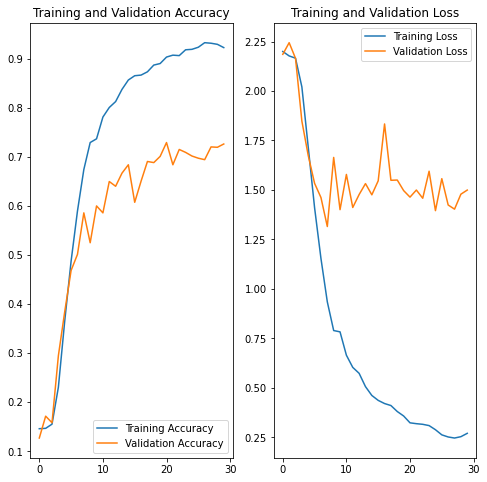

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

## Model 3: Findings

Model3 Findings and Conclusions

*    Final model has no overfitting or underfitting
*    Training accuracy is 91 % and validation accuracy is 70 %
*    We can observe significance improvement in training and validation accuracy after using Augmentor and treating imbalance of all the classes
*    More epochs can be added to increase the accuracy Further
*    Training and validation loss has been decreased with the increase in no of epochs

